In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
import pandas as pd
import numpy as np

Using TensorFlow backend.
F:\Anaconda\envs\hope\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\Anaconda\envs\hope\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\Anaconda\envs\hope\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\Anaconda\envs\hope\lib\site-packages\tensorflow\python\framework\dtypes.py:522: Future

In [2]:
# load train dataset and test dataset
file = 'no_head_tain.csv'
test = 'no_head_test.csv'
df = pd.read_csv(file, names=['reviews', 'sentiment'])
df_test = pd.read_csv(test, header = 0, names=['reviews', 'sentiment'])

In [21]:
# train model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['reviews'])
# max_features = len(list_tokenized_train)
maxlen = 500
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']

# define the structure
embed_size = 300
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.05))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 128
epochs = 5
model_path = 'model_weight.h5'
checkpointer = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=[checkpointer])


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 316s 16ms/step - loss: 0.4548 - acc: 0.7744 - val_loss: 0.4611 - val_acc: 0.8044

Epoch 00001: val_acc improved from -inf to 0.80440, saving model to model_weight.h5
Epoch 2/5
20000/20000 [==============================] - 321s 16ms/step - loss: 0.2309 - acc: 0.9102 - val_loss: 0.4177 - val_acc: 0.8264

Epoch 00002: val_acc improved from 0.80440 to 0.82640, saving model to model_weight.h5
Epoch 3/5
20000/20000 [==============================] - 322s 16ms/step - loss: 0.1587 - acc: 0.9439 - val_loss: 0.5358 - val_acc: 0.8000

Epoch 00003: val_acc did not improve from 0.82640
Epoch 4/5
20000/20000 [==============================] - 326s 16ms/step - loss: 0.1110 - acc: 0.9624 - val_loss: 0.4306 - val_acc: 0.8496

Epoch 00004: val_acc improved from 0.82640 to 0.84960, saving model to model_weight.h5
Epoch 5/5
20000/20000 [==============================] - 326s 16ms/step - loss: 0.0745 

In [22]:
# test model
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score


y_test = df_test["sentiment"]
list_sentences_test = df_test["reviews"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

pct_auc = roc_auc_score(y_pred, y_test) * 100
print('{:0.2f}'.format(pct_auc))
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

78.81
F1-score: 0.797006206644761
Confusion matrix:


array([[ 8524,  1584],
       [ 3976, 10915]], dtype=int64)

AUC :  0.7775949307944637


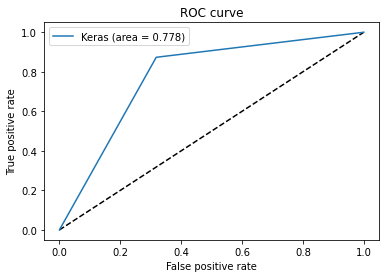

In [23]:
import matplotlib as plt
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import *
from sklearn.metrics import roc_curve, auc

# ROC Curve
# （True Positive Rate , TPR）or（sensitivity）
# （False Positive Rate , FPR）
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
print("AUC : ", auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

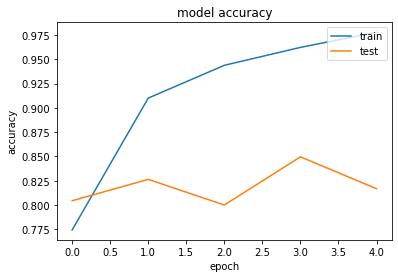

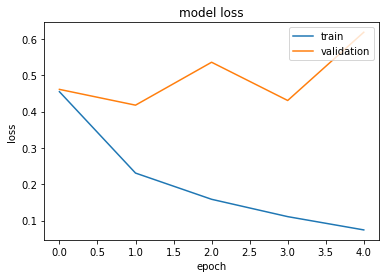

In [27]:
plt.plot(history.history[ 'acc' ])
plt.plot(history.history[ 'val_acc' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper right' )
plt.show()

plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'validation' ], loc= 'upper right' )
plt.show()


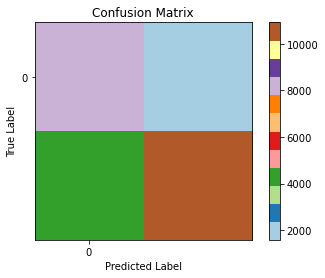

In [26]:
plt.imshow(confusion_matrix(y_pred, y_test),interpolation='nearest',cmap=plt.cm.Paired)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks=np.arange(1)
plt.xticks(tick_marks,tick_marks)
plt.yticks(tick_marks,tick_marks)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [9]:
from keras.models import load_model
model.save('model_weight.h5')